# Kaggle - Bike Sharing Demands - Model Improvement
**Author: Chris Shin**

In [2]:
# Standard Library imports
from datetime import datetime
import calendar

# Third-Party Library imports
import numpy as np
import pandas as pd
import matplotlib as mpl
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns

from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import OneHotEncoder, FunctionTransformer
from sklearn.metrics import make_scorer
from sklearn.model_selection import cross_val_score
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline

In [3]:
train = pd.read_csv('./data/train.csv')
test = pd.read_csv('./data/test.csv')
submission = pd.read_csv('./data/sampleSubmission.csv')

In [4]:
def feature_engineer(data):
    df = data.copy()
    df['weather'] = df['weather'].replace(4, 3)
    df['year'] = df['datetime'].apply(lambda x: x.split()[0].split('-')[0]).astype(int)
    df['month'] = df['datetime'].apply(lambda x: x.split()[0].split('-')[1]).astype(int)
    df['day'] = df['datetime'].apply(lambda x: x.split()[0].split('-')[2]).astype(int)
    df['hour'] = df['datetime'].apply(lambda x: x.split()[1].split(':')[0]).astype(int)
    df['weekday'] = df['datetime'].apply(lambda x: x.split()[0]).apply(lambda dateString: calendar.day_name[datetime.strptime(dateString, '%Y-%m-%d').weekday()])
    df['season'] = df['season'].map({1: 'Spring',
                                        2: 'Summer',
                                        3: 'Fall',
                                        4: 'Winter'})
    # df = pd.get_dummies(df, columns=['season', 'weekday'])

    # create an instance of the encoder with categorical feature indices
    encoder = OneHotEncoder(handle_unknown='ignore', sparse=False)
    categorical_cols = ['season', 'weekday']

    # fit and transform the encoded values to the DataFrame
    encoded_values = encoder.fit_transform(df[categorical_cols])
    feature_names = encoder.get_feature_names_out(input_features=['season', 'weekday'])
    df_encoded = pd.DataFrame(encoded_values, columns=feature_names)

    # drop original categorical columns and join the encoded DataFrame to the original
    df = df.drop(categorical_cols, axis=1)
    df = pd.concat([df, df_encoded], axis=1)

    drop_features = ['casual', 'registered', 'datetime', 'windspeed']
    df = df.drop([col for col in df.columns if col in drop_features], axis=1)
        
    return df

In [5]:
X_train = feature_engineer(train)
X_test = feature_engineer(test)

X_train = X_train.drop('count', axis=1)
y_train = train['count']

c:\Users\Yuchie\Desktop\DataScience\kaggle_env\Lib\site-packages\sklearn\preprocessing\_encoders.py:868: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
c:\Users\Yuchie\Desktop\DataScience\kaggle_env\Lib\site-packages\sklearn\preprocessing\_encoders.py:868: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(


In [6]:
def rmsle(y_true, y_pred, convertExp=True):

    if convertExp:
        y_true = np.exp(y_true)
        y_pred = np.exp(y_pred)

    log_true = np.nan_to_num(np.log(y_true + 1))
    log_pred = np.nan_to_num(np.log(y_pred + 1))

    rmsle_result = np.sqrt(np.mean((log_true - log_pred) ** 2))
    return rmsle_result

Hyperparameter tuning techniques can be broadly classified into two categories: exhaustive search methods and probabilistic search methods.

1. **`Exhaustive search methods`**
    - **Grid search**
        - In this method, all possible combinations of hyperparameters are tried out, and the performance metric is evaluated for each combination. 
        - It is simple and easy to implement, but it can be computationally expensive and time-consuming.
        - It can be used when the search space is small and the hyperparameters are independent of each other.
    - **Random search**
        - In this method, hyperparameters are randomly sampled from a predefined range or distribution, and the performance metric is evaluated for each combination.
        - It is less computationally expensive and can be faster than grid search, but it may not always find the optimal hyperparameters.
        - It can be used when the search space is large and the hyperparameters are not independent of each other.

2. **`Probabilistic search methods`**
    - **Bayesian optimization**
        - In this method, a probabilistic model is constructed to model the relationship between hyperparameters and the performance metric. The model is updated iteratively as new observations are made, and the next set of hyperparameters to be evaluated is chosen based on the model's posterior probability of being the optimal set of hyperparameters.
        - It can be more efficient than grid and random search, and can converge to the optimal hyperparameters quickly, but it requires defining a prior distribution and can be sensitive to the choice of hyperparameters
        - It can be used when the search space is large and the hyperparameters are not independent of each other, and when the objective function is expensive to evaluate.
    - **Genetic algorithms**
        - In this method, a population of candidate solutions is evolved using genetic operators such as mutation, crossover, and selection. The fitness function is evaluated for each candidate solution, and the fittest solutions are selected for the next generation.
        - It can explore a large search space and converge to the optimal solution, but it can be computationally expensive and sensitive to the choice of genetic operators.
        - It can be used when the search space is large and the hyperparameters are not independent of each other, and when the objective function is expensive to evaluate and has multiple local optima.

In [7]:
from sklearn.linear_model import Ridge
from sklearn.linear_model import Lasso
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import RandomizedSearchCV
from sklearn import metrics

In [8]:
ridge_model = Ridge()
ridge_params = {
    'max_iter': [3000],
    'alpha': [0.1, 1, 2, 3, 4, 10, 30, 100, 200, 300, 400, 800, 900, 1000],
    'solver': ['auto', 'svd', 'cholesky', 'lsqr', 'sparse_cg', 'sag', 'saga'],
    'fit_intercept': [True, False]
}

rmsle_scorer = metrics.make_scorer(rmsle, greater_is_better=False)

gridsearch_ridge_model = GridSearchCV(estimator=ridge_model,
                                      param_grid=ridge_params,
                                      scoring=rmsle_scorer,
                                      cv=5)

log_y_train = np.log(y_train)
gridsearch_ridge_model.fit(X_train, log_y_train)

print("Optimal hyperparameters : ", gridsearch_ridge_model.best_params_)

c:\Users\Yuchie\Desktop\DataScience\kaggle_env\Lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
c:\Users\Yuchie\Desktop\DataScience\kaggle_env\Lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
c:\Users\Yuchie\Desktop\DataScience\kaggle_env\Lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
c:\Users\Yuchie\Desktop\DataScience\kaggle_env\Lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
c:\Users\Yuchie\Desktop\DataScience\kaggle_env\Lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


Optimal hyperparameters :  {'alpha': 200, 'fit_intercept': True, 'max_iter': 3000, 'solver': 'lsqr'}


c:\Users\Yuchie\Desktop\DataScience\kaggle_env\Lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


In [9]:
preds = gridsearch_ridge_model.best_estimator_.predict(X_train) 

print(f'Ridge Regression RMSLE score : {rmsle(log_y_train, preds, True):.4f}') 

Ridge Regression RMSLE score : 1.0124


In [10]:

lasso_model = Lasso()
lasso_alpha = 1/np.array([0.1, 1, 2, 3, 4, 10, 30, 100, 200, 300, 400, 800, 900, 1000])
lasso_params = {
    'max_iter':[3000],
    'alpha':lasso_alpha,
    'fit_intercept': [True, False],
    'selection': ['cyclic', 'random']
}

gridsearch_lasso_model = GridSearchCV(estimator=lasso_model,
                                      param_grid=lasso_params,
                                      scoring=rmsle_scorer,
                                      cv=5)

log_y_train = np.log(y_train)
gridsearch_lasso_model.fit(X_train, log_y_train)

print('Optimal hyperparameters :', gridsearch_lasso_model.best_params_)

c:\Users\Yuchie\Desktop\DataScience\kaggle_env\Lib\site-packages\sklearn\linear_model\_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 4.188e+03, tolerance: 1.921e+01
  model = cd_fast.enet_coordinate_descent(
c:\Users\Yuchie\Desktop\DataScience\kaggle_env\Lib\site-packages\sklearn\linear_model\_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.483e+02, tolerance: 2.044e+01
  model = cd_fast.enet_coordinate_descent(
c:\Users\Yuchie\Desktop\DataScience\kaggle_env\Lib\site-packages\sklearn\linear_model\_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or co

Optimal hyperparameters : {'alpha': 0.005, 'fit_intercept': True, 'max_iter': 3000, 'selection': 'random'}


In [11]:
preds = gridsearch_lasso_model.best_estimator_.predict(X_train) 

print(f'Lasso Regression RMSLE score : {rmsle(log_y_train, preds, True):.4f}') 

Lasso Regression RMSLE score : 1.0125


In [12]:
from scipy.stats import uniform

ridge_model = Ridge()
ridge_params = {
    'max_iter': [3000],
    'alpha': uniform(loc=0, scale=1000),
    'solver': ['auto', 'svd', 'cholesky', 'lsqr', 'sparse_cg', 'sag', 'saga'],
    'fit_intercept': [True, False]
}

rmsle_scorer = metrics.make_scorer(rmsle, greater_is_better=False)

randomsearch_ridge_model = RandomizedSearchCV(estimator=ridge_model,
                                             param_distributions=ridge_params,
                                             n_iter=100,
                                             scoring=rmsle_scorer,
                                             cv=5,
                                             random_state=42)

log_y_train = np.log(y_train)
randomsearch_ridge_model.fit(X_train, log_y_train)

print("Optimal hyperparameters : ", randomsearch_ridge_model.best_params_)

c:\Users\Yuchie\Desktop\DataScience\kaggle_env\Lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
c:\Users\Yuchie\Desktop\DataScience\kaggle_env\Lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
c:\Users\Yuchie\Desktop\DataScience\kaggle_env\Lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
c:\Users\Yuchie\Desktop\DataScience\kaggle_env\Lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
c:\Users\Yuchie\Desktop\DataScience\kaggle_env\Lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


Optimal hyperparameters :  {'alpha': 195.9828624191452, 'fit_intercept': True, 'max_iter': 3000, 'solver': 'sag'}


c:\Users\Yuchie\Desktop\DataScience\kaggle_env\Lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


In [13]:
preds = gridsearch_ridge_model.best_estimator_.predict(X_train) 

print(f'Ridge Regression RMSLE score : {rmsle(log_y_train, preds, True):.4f}') 

Ridge Regression RMSLE score : 1.0124


In [14]:

lasso_model = Lasso()

lasso_params = {
    'max_iter':[3000],
    'alpha': uniform(loc=0.001, scale=0.999),
    'fit_intercept': [True, False],
    'precompute': [True, False],
    'selection': ['cyclic', 'random'],
    'tol': uniform(loc=0, scale=0.01)
}

gridsearch_lasso_model = RandomizedSearchCV(estimator=lasso_model,
                                             param_distributions=lasso_params,
                                             n_iter=100,
                                             scoring=rmsle_scorer,
                                             cv=5,
                                             random_state=42)

log_y_train = np.log(y_train)
gridsearch_lasso_model.fit(X_train, log_y_train)

print('Optimal hyperparameters :', gridsearch_lasso_model.best_params_)

Optimal hyperparameters : {'alpha': 0.00805923891449769, 'fit_intercept': True, 'max_iter': 3000, 'precompute': True, 'selection': 'cyclic', 'tol': 0.006118528947223795}


In [15]:
preds = gridsearch_lasso_model.best_estimator_.predict(X_train) 

print(f'Lasso Regression RMSLE score : {rmsle(log_y_train, preds, True):.4f}') 

Lasso Regression RMSLE score : 1.0130


Ridge, Lasso, Random Forest Regression, and Support Vector Machines (SVM) are all commonly used regression algorithms with their own strengths and weaknesses. Here is a brief overview of each:

1. Ridge Regression:
    - Pros:
        - Helps to avoid overfitting by penalizing large coefficients with L2 regularization.
        - Can handle multicollinearity well.
        - Works well when most of the variables in the dataset are useful for the prediction.
    - Cons:
        - Does not perform feature selection and keeps all the variables in the model.
        - The results can be sensitive to the choice of regularization parameter.
    - When to use:
        - When there are many variables in the dataset and all or most of them are thought to be relevant for the prediction.
        - When multicollinearity is present.
2. Lasso Regression:
    - Pros:
        - Helps to avoid overfitting by penalizing large coefficients with L1 regularization.
        - Performs feature selection by shrinking the coefficients of irrelevant variables to zero.
        - Can handle multicollinearity well.
    - Cons:
        - The results can be sensitive to the choice of regularization parameter.
        - May not work well if there are many variables with small effects.
    - When to use:
        - When feature selection is important.
        - When the number of variables is large but only a small subset is thought to be relevant for the prediction.
3. Random Forest Regression:
    - Pros:
        - Can handle both numerical and categorical variables.
        - Handles interactions between variables well.
        - Robust to outliers and noise in the data.
        - Does not require feature scaling.
    - Cons:
        - Can be computationally expensive for large datasets and complex models.
        - May overfit if the number of trees is too large.
    - When to use:
        - When there is a mix of categorical and numerical variables.
        - When interactions between variables are important.
        - When the data contains outliers or noise.
4. Support Vector Machines:
    - Pros:
        - Effective in high-dimensional spaces.
        - Works well in cases where the number of dimensions is greater than - the number of samples.
        - Can handle non-linear boundaries.
        - Performs feature selection by using the support vectors.
    - Cons:
        - Can be sensitive to the choice of kernel function and its parameters.
        - Can be computationally expensive for large datasets.
    - When to use:
        - When the number of features is high and the number of samples is low.
        - When there are non-linear boundaries between the classes.
        - When feature selection is important.

Overall, the choice of algorithm depends on the specific characteristics of the dataset and the problem at hand. It's a good idea to try out different algorithms and compare their performance using cross-validation to choose the best one.

### Modeling with RandomForestRegressor

In [16]:
from sklearn.ensemble import RandomForestRegressor

randomforest_model = RandomForestRegressor()

rf_params = {
    'n_estimators': [100, 200, 300], # number of trees in the forest
    'max_depth': [None, 10, 20], # maximum depth of the tree
    'min_samples_split': [2, 5, 10], # minimum number of samples required to split an internal node
    'min_samples_leaf': [1, 2, 4], # minimum number of samples required to be at a leaf node
    'max_features': ['auto', 'sqrt'], # number of features to consider when looking for the best split
    'bootstrap': [True, False], # whether to bootstrap the samples used for each tree
    'random_state': [42]
}
gridsearch_random_forest_model = GridSearchCV(estimator=randomforest_model,
                                              param_grid=rf_params,
                                              scoring=rmsle_scorer,
                                              cv=5)

log_y_train = np.log(y_train)
gridsearch_random_forest_model.fit(X_train, log_y_train)

print('Optimal hyperparameters :', gridsearch_random_forest_model.best_params_)

c:\Users\Yuchie\Desktop\DataScience\kaggle_env\Lib\site-packages\sklearn\ensemble\_forest.py:413: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(
c:\Users\Yuchie\Desktop\DataScience\kaggle_env\Lib\site-packages\sklearn\ensemble\_forest.py:413: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(
c:\Users\Yuchie\Desktop\DataScience\kaggle_env\Lib\site-packages\sklearn\ensemble\_forest.py:413: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remov

Optimal hyperparameters : {'bootstrap': True, 'max_depth': None, 'max_features': 'auto', 'min_samples_leaf': 2, 'min_samples_split': 2, 'n_estimators': 100, 'random_state': 42}


In [17]:
preds = gridsearch_random_forest_model.best_estimator_.predict(X_train)

print(f'Random Forest Regression RMSLE score : {rmsle(log_y_train, preds, True):.4f}')

Random Forest Regression RMSLE score : 0.1531


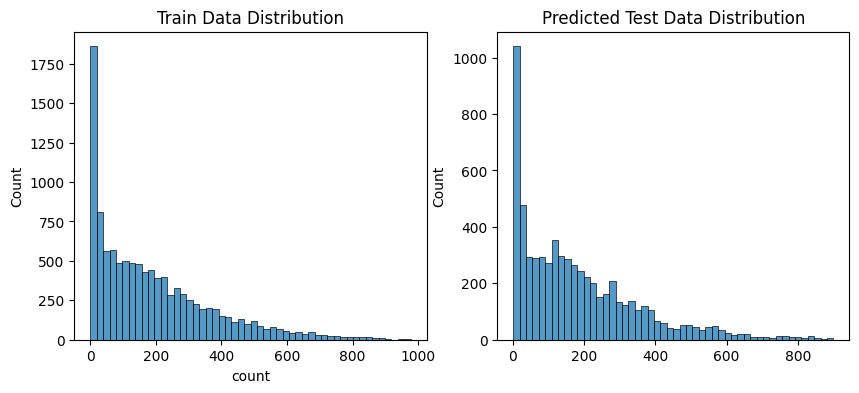

In [18]:
import seaborn as sns
import matplotlib.pyplot as plt

randomforest_preds = gridsearch_random_forest_model.best_estimator_.predict(X_test)

figure, axes = plt.subplots(ncols=2)
figure.set_size_inches(10, 4)

sns.histplot(y_train, bins=50, ax=axes[0])
axes[0].set_title('Train Data Distribution')
sns.histplot(np.exp(randomforest_preds), bins=50, ax=axes[1])
axes[1].set_title('Predicted Test Data Distribution');

In [19]:
preds = gridsearch_random_forest_model.best_estimator_.predict(X_test)
submission['count'] = np.exp(preds)
submission.to_csv('submission.csv', index=False)

There are several regression models available in machine learning. Here are some of the most common ones and their advantages and disadvantages:

1. Linear Regression:
    - Advantages: simple and interpretable model, fast to train and predict, can handle large datasets with many features.
    - Disadvantages: assumes a linear relationship between the dependent and independent variables, can be sensitive to outliers and multicollinearity.
2. Ridge Regression:
    - Advantages: can handle multicollinearity and prevent overfitting, good for high-dimensional datasets, can work well even if some of the predictors are irrelevant.
    - Disadvantages: introduces a tuning parameter (alpha), which needs to be carefully chosen.
3. Lasso Regression:
    - Advantages: can perform feature selection and reduce the number of irrelevant predictors, good for high-dimensional datasets, can work well even if some of the predictors are irrelevant.
- Disadvantages: introduces a tuning parameter (alpha), which needs to be carefully chosen, may not work well if the number of predictors is larger than the number of observations.
4. Elastic Net Regression:
    - Advantages: can handle multicollinearity and prevent overfitting, can perform feature selection and reduce the number of irrelevant predictors, good for high-dimensional datasets.
    - Disadvantages: introduces two tuning parameters (alpha and l1_ratio), which need to be carefully chosen.
5. Support Vector Regression (SVR):
    - Advantages: can handle nonlinear relationships between the dependent and independent variables, can work well with small to medium-sized datasets, can handle high-dimensional datasets with suitable kernel functions.
    - Disadvantages: requires careful selection of kernel function and its parameters, slower to train than linear models, sensitive to outliers.
6. Decision Tree Regression:
    - Advantages: can handle nonlinear relationships and interactions between the dependent and independent variables, can work well with small to medium-sized datasets, easy to interpret and visualize.
    - Disadvantages: prone to overfitting, sensitive to small changes in the data, can create biased trees if some classes dominate.
7. Random Forest Regression:
    - Advantages: can handle nonlinear relationships and interactions between the dependent and independent variables, can work well with small to medium-sized datasets, less prone to overfitting than decision trees, can handle missing values and categorical data, easy to parallelize.
    - Disadvantages: may not work well with very high-dimensional datasets, less interpretable than decision trees.
8. Gradient Boosting Regression:
    - Advantages: can handle nonlinear relationships and interactions between the dependent and independent variables, can work well with small to medium-sized datasets, less prone to overfitting than decision trees, can handle missing values and categorical data, can perform feature selection, can handle outliers.
    - Disadvantages: requires careful tuning of parameters, slower to train than linear models, can be sensitive to noisy data.

Neural networks can be very effective for regression tasks, but whether they are the best choice depends on the specific problem and data. Here are some advantages and disadvantages of using neural networks for regression:

- Advantages:
    - Neural networks can model highly complex relationships between inputs and outputs, allowing them to capture subtle patterns in the data.
    - They are highly flexible and can be designed to handle various types of input data, including both numerical and categorical variables.
    - Neural networks can handle missing data and outliers effectively by learning from patterns in the data.
- Disadvantages:
    - Neural networks are computationally intensive and may require a lot of resources to train and optimize, especially for large datasets or complex architectures.
    - They can be prone to overfitting, especially if the model is too complex or there is not enough data to support the number of parameters.
    - Interpreting the results of a neural network model can be challenging, as the underlying relationships learned by the model are often difficult to understand or visualize.

In general, neural networks can be a good choice for regression tasks when there is a large amount of data and complex relationships between inputs and outputs that cannot be easily modeled by other regression methods. However, for smaller datasets or simpler problems, other regression models such as linear regression, decision trees, or random forests may be more appropriate and easier to interpret.

In [ ]:
from keras.models import Sequential
from keras.layers import Dense

# create a neural network model
model = Sequential()
model.add(Dense(64, input_dim=X_train.shape[1], activation='relu'))
model.add(Dense(32, activation='relu'))
model.add(Dense(1, activation='linear'))

# compile the model
model.compile(loss='mean_squared_error', optimizer='adam')

# fit the model to the training data
model.fit(X_train, y_train, epochs=100, batch_size=32, validation_split=0.2)

# evaluate the model on the test data
mse = model.evaluate(X_test, y_test)

# make predictions with the model
y_pred = model.predict(X_test)

In [ ]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from kerastuner import HyperModel

# Define the model architecture
def build_model(hp):
    model = keras.Sequential()
    model.add(layers.Dense(units=hp.Int('units_1', min_value=32, max_value=512, step=32), activation='relu', input_dim=X_train.shape[1]))
    for i in range(hp.Int('num_layers', 1, 10)):
        model.add(layers.Dense(units=hp.Int(f'units_{i+2}', min_value=32, max_value=512, step=32), activation='relu'))
    model.add(layers.Dense(units=1))
    
    # Compile the model
    model.compile(optimizer=keras.optimizers.Adam(hp.Choice('learning_rate', values=[1e-2, 1e-3, 1e-4])),
                  loss='mse',
                  metrics=['mae'])
    return model

# Instantiate the HyperModel
hypermodel = HyperModel(build_model)

# Define the tuner and search for the best hyperparameters
tuner = RandomSearch(hypermodel,
                     objective='val_loss',
                     max_trials=10,
                     executions_per_trial=2,
                     directory='my_dir',
                     project_name='my_project')

tuner.search(X_train, y_train,
             epochs=100,
             validation_data=(X_val, y_val))

# Get the best model
best_model = tuner.get_best_models(num_models=1)[0]